In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [2]:
df = pd.read_csv('data/CSVs/Created/tweet_data.csv', low_memory=False)

In [4]:
df = df.loc[df['flagged'] == 1]

In [6]:
data = list(df['content'])
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]

<>:2: DeprecationWarning: invalid escape sequence \S
<>:3: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \S
<>:3: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \S
<>:3: DeprecationWarning: invalid escape sequence \s
/var/folders/6l/66ffj7kd6vbgh6tqdhdwn_840000gn/T/ipykernel_27547/2210632844.py:2: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
/var/folders/6l/66ffj7kd6vbgh6tqdhdwn_840000gn/T/ipykernel_27547/2210632844.py:3: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
data_words = list(sent_to_words(data))

In [8]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [9]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=[
   'NOUN', 'ADJ', 'VERB', 'ADV'
])

In [11]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [12]:
lda_model = gensim.models.ldamodel.LdaModel(
   corpus=corpus, id2word=id2word, num_topics=20, random_state=100, 
   update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True
)

In [13]:
mallet_path = 'data/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 90
total tokens: 3125
<10> LL/token: -9.70695
<20> LL/token: -9.51937
<30> LL/token: -9.49922
<40> LL/token: -9.43019

0	2.5	time mad shooter end bad play put knife push texas nigga honestly send child stop jump stupid picture whine mockery 
1	2.5	ass https hope school hear shit wanna guess act tonight night give drive smart tip deal idea garden youn cfazrp 
2	2.5	shoot school police medium crazy lol bullet red yesterday nee heroin morning sun location child world vote worry friday facebook 
3	2.5	feel drop rap leave shit amp law home country favor lay piss january boy crime remember black soooo die havoc 
4	2.5	bomb day lmao car death truck lock remember bring cat beast meeting damn party gas plastic pizza white put life 
5	2.5	year girl today shot hair ill talk fire police work big pull nigga office problem slow wait war strap fun 
6	2.5	murder back baby watch wrong hurt tired taylor american ughh absolute

<160> LL/token: -9.39075
<170> LL/token: -9.36113
<180> LL/token: -9.32454
<190> LL/token: -9.28886

0	2.5	police year start shot find death fucking play drive sleep pant st walk offense concerned abq rn meeting pay miss 
1	2.5	https shooter hate lose bad law set dumbass mom incident big open lebron deal vote shit pizza accomplishment trump intentionally 
2	2.5	shoot today hair lock bleed night leg log count piss january week hold foot bunch akatsuki judge spectrumgrade vagina honestly 
3	2.5	back hope amp mad commit head fall full child office hand time love noah period listen stop shit break feel 
4	2.5	murder lmao week fire hard overdose change terrify black love completely navigate dead sad bullet flag home gas foot stupid 
5	2.5	time die hit carry literally story notice end floor ughh afraid season cuz lay burn brandon leave proud workout mbgr 
6	2.5	murder nigga watch bitch lol act social wtf morris weapon pee assault twitt red rest suburb sound ion marcuse minor 
7	2.5	https fee

<330> LL/token: -9.35758
<340> LL/token: -9.36693

0	2.5	call police feel kid talk story tail smart pant office bleed yesterday morris beast town sing thing crime slow hand 
1	2.5	https start year campus fire wtf count world clark film charge dad girl murder white aaaaaaaaand promise facebook defense series 
2	2.5	shoot people today big sick threat nerve lot mental_breakdown pee move risk rn st worry oppose accomplishment rifle past disgust 
3	2.5	shoot hope drop lockdown mad hear lol play thing texas listen baby smell floor county sister lady threaten twitt red 
4	2.5	murder bitch people leave full money point drive touch log weapon rah hftqi wednesday dig documentary parking minato highschool pqs 
5	2.5	shit house news end set pull literally jefferson foot throw hold burn black level imma racist friday admit sound force 
6	2.5	die watch hair fucking head dude overdose favor woman shut remember identify type fall rap pick scream gri melt cat 
7	2.5	amp kill death home love law terrify

<510> LL/token: -9.34773
<520> LL/token: -9.31982
<530> LL/token: -9.34435
<540> LL/token: -9.36011

0	2.5	call police sniper wrong check town piss act nigga hand run cop dig kno sleeve susano farmlife strong chili associate 
1	2.5	kill ill heart play happen move notice person sadness lose cousin illegal cop deserve morris asshole large department ludlow fade 
2	2.5	people https hate change listen knife house life wtf tattoos coronado money wanna dead january hit idea hard jail workout 
3	2.5	shoot bitch car lol night hurt tired red home ball noah cute imma mom cool pta gardener jaylen somebodys iedp 
4	2.5	time shit thing start lockdown gon commit truck situation bleed charge catch offense leg proof dollar abortion aaaaaaaaand marketing roomba 
5	2.5	shooter school kill matter gun lot game rah pee roof texas date pay film truck lock imagine xyqrly past det 
6	2.5	make woman drop die damn threat terrify vote fuck ion laugh morning pro meeting happy bunch hftqi ugly chicago hoe 
7	2.5	a

<690> LL/token: -9.34716

0	2.5	call police put talk damn texas listen kick crime oppose gym smell grade navigate wanna dead great threaten jump kid 
1	2.5	kill drop run guess office hear knife guy wtf tip heroin circulate absolute notice lay sad yesterday karma absolutely uugnur 
2	2.5	https people feel murder tax terrify play carry friend game tail child big start nee full dollar aornqfqsmj person bullet 
3	2.5	shoot good today country start move favor hour https rn hand remember fall cat stupid proud chicom strap key force 
4	2.5	time give shit bad wrong threat home worry quick murder side recently top idea level identify dig marcuse isaacason lyrically 
5	2.5	back hope love watch baby mad matter literally life tho happy afraid concerned overdose sing deal fake heart story set 
6	2.5	woman shooter bitch hair teacher kill abortion lose hard guy beast ughh weapon morning nerve remember plastic war store share 
7	2.5	amp end jail head walk class mental_breakdown plant drive lose americ


0	2.5	police call girl bitch jail lol check assault white rah pro sing rn level happy cousin whine youn marcuse spiral 
1	2.5	shoot kill walk tax tho full change money favor terrify lot pee ppl jihadist idea catch smell sniper stupid trump 
2	2.5	people https rap sniper night hurt shut america read log property absolute dollar season occur hell quick random shoot senpai 
3	2.5	good shit amp death crazy cop law talk run fall overdose sad tired tow bring miss hour plastic war chicom 
4	2.5	time big hard friend murder process incident throw mental_breakdown damn slow cat stfu navigate listen dead january mom pull shooter 
5	2.5	feel thing watch truck baby end act ill push tonight mental_breakdown home hear open weapon heroin cute aornqfqsmj fight sell 
6	2.5	https woman week kid story matter child social proof laugh screen rosa meeting gri hold oppose bitch racist hifh yuck 
7	2.5	fuck care nigga situation pay drive jefferson tail send count class dumbass foot touch scream parent drug xy

In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [15]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 90
total tokens: 3125
<10> LL/token: -8.80904
<20> LL/token: -8.73999
<30> LL/token: -8.72738
<40> LL/token: -8.68953

0	25	kill shoot school https shooting bomb student people call fuck day good hobbs_high police woman elementary hit face_charge drop hear 
1	25	https murder gun man time make die ass school shooter rap back hope girl feel give shit bitch year amp 

<50> LL/token: -8.7041
<60> LL/token: -8.68406
<70> LL/token: -8.679
<80> LL/token: -8.68518
<90> LL/token: -8.69253

0	25	school kill shoot https shooting bomb student call fuck police day hobbs_high woman shooter elementary back hit face_charge hear nigga 
1	25	https murder gun people man rap time make good die ass hope girl feel give shit bitch year amp love 

<100> LL/token: -8.67608
<110> LL/token: -8.69987
<120> LL/token: -8.66589
<130> LL/token: -8.65765
<140> LL/token: -8.66591

0	25	kill school shoot shooting bomb student call fuck police day 

<60> LL/token: -8.99602
<70> LL/token: -9.01389
<80> LL/token: -8.99309
<90> LL/token: -8.98614

0	6.25	kill call girl love hate week watch matter work heart money tail point push pant mom problem crime read burn 
1	6.25	murder ass put house hear hair back fire walk child wanna fight damn run yesterday grade process tonight throw abortion 
2	6.25	shoot good elementary thing drop baby car lose jail find tax commit break lock jefferson hard game night move law 
3	6.25	gun bomb people make fuck police sniper care truck fucking talk check full crazy guess tho carry knife foot change 
4	6.25	school shooting student hobbs_high hope face_charge start hobb news situation pull kick medium threat hoax class lebron high threaten social 
5	6.25	time man day woman bitch feel amp today mental_breakdown kid hit ill lol guy bad death play remember wrong pay 
6	6.25	https rap shooter nigga lmao police parent back leave act taylor lot dude bring sleep listen incident hand set ion 
7	6.25	shoot die give 

<460> LL/token: -8.89497
<470> LL/token: -8.95012
<480> LL/token: -8.96732
<490> LL/token: -8.97308

0	6.25	murder back give love hate kid start put fight story full money child america drive fall game touch send point 
1	6.25	call fuck police murder die feel mad hear hair car lose play shooting shooter situation lol office carry friend knife 
2	6.25	shoot day good ass hope shit bitch drop nigga today guy death act campus tho jefferson foot cop smart overdose 
3	6.25	kill make people girl bomb thing week watch sniper care end fucking stop tax tonight happen yesterday life count push 
4	6.25	school student shooting hobbs_high elementary face_charge mental_breakdown parent medium hobb ill talk news lockdown wanna terrify bring hoax high social 
5	6.25	gun rap time man woman hit house find baby bad leave head run people check gon big remember literally hard 
6	6.25	https bomb shooter fire walk set lot pull lock night tail class heart damn burn identify nee catch dad side 
7	6.25	kill shoo

<860> LL/token: -8.95511
<870> LL/token: -8.93601
<880> LL/token: -8.98899
<890> LL/token: -8.97734

0	6.25	murder kill girl bitch thing mental_breakdown kid sniper day hair lose heart play child wanna act office drive literally fall 
1	6.25	kill fuck good die elementary back give shit amp stop love care matter death story america damn carry hard count 
2	6.25	gun ass shooter put house day mad end ill run talk home lock jefferson touch threat hold worry miss type 
3	6.25	bomb people call police make hate start car truck campus lot black life send money texas hurt cut world dumbass 
4	6.25	school shooting student hobbs_high face_charge drop week bad medium fucking hobb parent news lol full guess pay dude knife game 
5	6.25	https man rap time woman nigga baby hope work head tax tonight kick tho friend foot push pant tired person 
6	6.25	https feel year hit today find leave jail lockdown fire remember wrong terrify yesterday country set grade class mom red 
7	6.25	shoot kill hear lmao sho

<160> LL/token: -9.22715
<170> LL/token: -9.19311
<180> LL/token: -9.17749
<190> LL/token: -9.20078

0	3.57143	shit run truck lol leave guy crazy taylor pull commit dude gun tail guess listen notice teacher red bring smell 
1	3.57143	murder day give mental_breakdown heart happen fire man set talk tho break world campus hate bleed charge knife offense ughh 
2	3.57143	people mad hear shooter end hair lose lockdown walk pay remember lock jefferson overdose hold america chicken side period date 
3	3.57143	feel amp put nigga start shooter head foot pant move boy sell pain plant heroin push lil dumbass terrify sad 
4	3.57143	https kill man shoot play check yesterday dad elementary top pro process wanna terrify threaten lmao playlist show threat fuck 
5	3.57143	https thing work death gon money sick tired incident week story sister favor dead hate tow spot jihadist add hard 
6	3.57143	gun elementary drop house ill home lmao child kid country wrong hurt cut miss white wait jail ion screen conce

<410> LL/token: -9.16175
<420> LL/token: -9.15684
<430> LL/token: -9.20612
<440> LL/token: -9.22266

0	3.57143	man bomb time woman start house play head texas move throw abortion shooter cole location dollar notice sing law spot 
1	3.57143	https hate gym office stop social tattoos rah serve process rn break story find rack pta extra kno parking minor 
2	3.57143	people shit hear love medium find police big sick money favor vote computer roof period piss minute world woman shut 
3	3.57143	https ass hope shooter kid lol leave lot pull fire dude cut lay problem incident morris stfu news flag idea 
4	3.57143	make year https mental_breakdown ill care lmao truck fight crazy death damn remember lock sleep pant hurt listen campus wtf 
5	3.57143	rap police girl bomb shot matter talk pay drive teacher hand quick catch ball white wait proof laugh afraid property 
6	3.57143	gun die bitch put end car baby guess literally friend send terrify week illegal smell knife touch beast noah tuesday 
7	3.5714

<660> LL/token: -9.17181
<670> LL/token: -9.15281
<680> LL/token: -9.18809
<690> LL/token: -9.15143

0	3.57143	time make put thing find end hit baby friend sleep hate stab jail kill tattoos drug worry racist touch night 
1	3.57143	https hair play wanna campus death walk ball life overdose pant move problem nerve fire risk lady jump fall soooo 
2	3.57143	call police bitch give sniper happen pull kick commit leave noah honestly send laugh afraid recently absolute navigate spot black 
3	3.57143	https kill day elementary work taylor bring person st oppose smell die abq aornqfqsmj terrorist plant marco brandon sick pass 
4	3.57143	rap girl shooter shot nigga home lose child law terrify office game class drive yo circulate roof piss date dead 
5	3.57143	bomb stop rap today remember lol act medium literally cut listen wild boy abortion hold carry american catch wait guy 
6	3.57143	gun man kid head start cop wrong hurt dumbass bleed read field identify lock leave floor full screen imma eat 
7	

<910> LL/token: -9.17001
<920> LL/token: -9.17132
<930> LL/token: -9.22944
<940> LL/token: -9.19052

0	3.57143	https time good hear sniper office damn lock fall burn quick hour beast notice person clark drug kid soooo put 
1	3.57143	kill die https amp find run matter guess pull yesterday friend foot hard knife favorite offense waste scream rn dumbass 
2	3.57143	police call murder give parent home kid point change lot pay remember hell miss illegal bomb overdose pro sister risk 
3	3.57143	rap shooter house hair walk tax terrify sick touch abortion st wtf weapon count absolute dollar dead sing sake problem 
4	3.57143	shoot hope girl year talk story truck tonight mom wild commit assault carry catch open floor honestly cole tip sleep 
5	3.57143	ass hit thing shot gun hate woman lockdown lol kick america jefferson texas hurt process chicken roomba smart stfu afraid 
6	3.57143	gun make drop today start baby gym dude pant lay boy plant head identify nee smell leg tattoos proof rah 
7	3.57143	

<110> LL/token: -9.39105
<120> LL/token: -9.38326
<130> LL/token: -9.37418
<140> LL/token: -9.36254

0	2.5	bomb elementary drop kill bring taylor st fire screen computer tonight person mad break plastic oven melt cat karma absolutely 
1	2.5	https people country cop pain damn hard beast spank concerned date sake imma incident thing jihadist mad stupid koc havoc 
2	2.5	make bomb hope ill run tax play jefferson lot plant mad stab pick lady time fall war strap hftqi city 
3	2.5	https rap death leave situation teacher level nee ion cole tip account sad kick lockdown yesterday illegal lock ball admit 
4	2.5	murder lmao baby amp hobb mental_breakdown car home walk problem office face_charge tattoos pee lay drug imagine xyqrly jfk suggest 
5	2.5	murder day jail terrify thing commit grade big bullet dude honestly cut accident bunch double det deserve yx morris jaylen 
6	2.5	man time bitch lose gon send hope hell hour people amp circulate roof wild hold story terrorize fall click kakuzu 
7	2.5	g

<260> LL/token: -9.26489
<270> LL/token: -9.34005
<280> LL/token: -9.35702
<290> LL/token: -9.38644

0	2.5	shot today talk death fire night hurt matter lebron heart shut drive car field end beast ughh risk control play 
1	2.5	https bitch happen law tho push white offense morris side morning scream sing sad abortion st pizza stupid key dalla 
2	2.5	make girl lockdown mad shooter head game pay chicken tail recently celtic boy wait wick john wen cheat scorch parking 
3	2.5	kill back give watch wrong break hold identify cute favor matter january spot level hour plastic xyqrly det gardener helen 
4	2.5	bomb love shooter parent run money big teacher care lose worry today roomba completely property constantly truck wreak promise past 
5	2.5	rap set bitch tonight bullet bleed hand remember care miss lol cop noah aornqfqsmj fact fake sell mad carry follow 
6	2.5	shoot kill elementary thing hit situation campus gon texas process american count pro clark marco lock random picture dig pta 
7	2.5	g

<440> LL/token: -9.2843

0	2.5	shit shot today check feel office touch ball gon world put ughh circulate abq favor sing tired nerve jump oppose 
1	2.5	https die hair gym situation drive night point count bullet assault favorite pee move class gri brandon absolutely shotgun rifle 
2	2.5	hate nigga act story sick hurt tonight notice crime identify wait roomba pick location concerned listen lebron literally sheet stupid 
3	2.5	hit lmao baby guy child remember abortion year truck heroin absolute roof period dead wild quick cousin nee lock strap 
4	2.5	bomb make time find lol play woman heart game laugh town tow spot threaten plant marco suggest pussy force marcuse 
5	2.5	shooter school stop talk medium tho week car happy knife offense sun sister rn deal film sbbhxalotp wreak facebook documentary 
6	2.5	https elementary love hope crazy taylor pull fire law vote read hard ion morris pro lay throw hit st today 
7	2.5	gun mad lot dude smart problem bring truck side proof risk sake terrorist da

<610> LL/token: -9.31075
<620> LL/token: -9.34207
<630> LL/token: -9.29761
<640> LL/token: -9.29069

0	2.5	hear ill bad watch ball process black red guy leg hobbs concerned piss risk january lay shut assault happy day 
1	2.5	https mental_breakdown people check damn pant class jefferson love property period fall find strap admit akatsuki mention spiral define fhrom 
2	2.5	give love lol sniper crazy office teacher leave send problem type lock open location tow spot today oppose uugnur workout 
3	2.5	shoot rap ass year nigga remember find move world dumbass abortion illegal log roof dead pam carry cousin country melt 
4	2.5	bomb stop drop work time tonight texas heroin incident lady news life technique lenient dalla facebook ggkauq gardener exist operate 
5	2.5	mad home shooter amp full fight week threaten back film friend smell end tip fake gas cat touch vighn mlz 
6	2.5	elementary kid day fucking story dude count hurt pay dad guy rah wanna imma jihadist america twitt lose hour brandon 


<790> LL/token: -9.37368

0	2.5	shooter girl watch law gon change white stfu pee town process celtic mom red worry gas brandon uugnur picture documentary 
1	2.5	make house give start home full wrong amp send favor sick die morris noah pant fake shut literally chicken police 
2	2.5	murder time today pull texas illegal morning recently overdose clark knife admit kakuzu pussy honey somebodys bfe gold large pit 
3	2.5	shoot walk wanna cop nerve thing assault hand sing carry idea lenient fuu cheat dem susano austin lover drone beauty 
4	2.5	kill hope lockdown baby back jefferson listen dumbass bullet plant shooting fall jail absolute stop love aaaaaaaaand chicom mlz chicago 
5	2.5	year fuck care car shoot remember story tax parent hit commit country hard tired problem tattoos pick incident play oven 
6	2.5	good elementary nigga lmao taylor damn bring grade boy hour https eat meeting random wait suggest shotgun hypothesis define grrrr 
7	2.5	gun die hate tho black kid sleep matter play fire 

<960> LL/token: -9.38155
<970> LL/token: -9.33909
<980> LL/token: -9.37305
<990> LL/token: -9.3917

0	2.5	call police today send hurt sell dad pee concerned chicken brandon hard cop mlz fun documentary gardener sound hlybtynuc isaacason 
1	2.5	feel start death guess head bitch count commit sick man wtf dead twitt eye life suburb hoe double defenseless fuu 
2	2.5	murder time die mental_breakdown run wanna bleed burn recently dollar meeting pam fake slow strap hftqi ggkauq garden vol dramatic 
3	2.5	shoot make https gym remember break yesterday year lol roomba beast weapon favor world imma deal bullet stupid life sbbhxalotp 
4	2.5	kill people baby situation gon pull smart law country foot top defend cut terrorist marco share accomplishment vacuum chicago mbgr 
5	2.5	kill drop play day notice throw pay happen field nee ion hobbs wild person race identify miss melt love click 
6	2.5	https elementary house hobbs_high bring touch damn lockdown shoot rosa idea random wait bunch day karma key 

<110> LL/token: -9.50405
<120> LL/token: -9.50671
<130> LL/token: -9.44699
<140> LL/token: -9.51362

0	1.92308	man murder sniper lebron nerve leg sister lay gri drive cousin soooo strap fuu extra judge oldglory large db bernandino 
1	1.92308	week start leave fire wait completely cute problem incident abortion terrorize man cop ggkauq gardener blood ran butt spectrumgrade dronepic 
2	1.92308	people time bomb plant log hour archery mbgr deserve aurora sleeve philosophie comfortable beauty pit fate allison bird mystery rpxpd 
3	1.92308	school shooting student hobbs_high face_charge hobb recently official hoax computer material count type forever past je youn asshole vagina bud 
4	1.92308	kill put https send account overdose absolute top piss dead teacher happy end cop xyqrly vighn mlz technique tally spiral 
5	1.92308	day https parent crazy ion beast marco red fall kill city bfe qfhv layout window society hoax property heathly spank 
6	1.92308	call police ass happen money news crime assau

<260> LL/token: -9.44335
<270> LL/token: -9.49278
<280> LL/token: -9.46287
<290> LL/token: -9.47009

0	1.92308	hate love ill die hope lock world death film pay happy cousin today random life vacuum fun documentary hifh double 
1	1.92308	rap watch gun situation break send matter cop leg completely proof recently circulate roof crime drug cat accomplishment mlz workout 
2	1.92308	time fight medium give hope texas big mad account imma heart run nee leboproud john yuck mz confrontation brb tupac 
3	1.92308	school shooting student hobbs_high face_charge hobb parent news screen official computer wrong twitt sbbhxalotp strap lenient je curiosity helen tztf 
4	1.92308	school nigga money walk kill guess act person hold fire leave concerned sing carry havoc dig senpai dramatic isaacason susano 
5	1.92308	https hair sell smell jail mom st stupid karma akatsuki socrate mockery bud envy mystery cfhphwq redistribute russia cheer jaiden 
6	1.92308	police call full lmao guy favor bleed yesterday rap j

<410> LL/token: -9.47718
<420> LL/token: -9.47928
<430> LL/token: -9.47694
<440> LL/token: -9.49018

0	1.92308	mental_breakdown school week hate threat life smart class process hair tired favorite amp shot morning period pay sheet live kill 
1	1.92308	murder ill jail smell https navigate fake pay jihadist drug marco field past yuck dem eventually afraid ixwt kaney disciplinary 
2	1.92308	shoot die tho crime constantly shit touch random yo house chicom lenient jfk promise kakuzu aurora teaching hlybtynuc comfortable side 
3	1.92308	school shooting student hobbs_high face_charge roomba log hobbs computer account hobb year love suggest ran offense tattoos side meat vovpmqrez 
4	1.92308	https shooter school rap lol remember watch dude nee open proof tow girl sniper gun friday shotgun archery intentionally yx 
5	1.92308	https hoax medium weapon send absolute top pro social key hftqi wreak je kinda doughnut pastor ohhya regard band adam 
6	1.92308	call police girl head full damn tail listen 

<560> LL/token: -9.51509
<570> LL/token: -9.58539
<580> LL/token: -9.53703
<590> LL/token: -9.53132

0	1.92308	kill put money tax yesterday wtf side honestly tip computer office break dude soooo life share uugnur hftqi wednesday jfk 
1	1.92308	murder bad heart big hope bleed process rosa tow drug hear promise dig wick aurora boyfriend dem cfazrp detail beach 
2	1.92308	https hope shooter hear kid fall send mom illegal nee friend morning hair pam teacher play plant picture intentionally log 
3	1.92308	school shooting student hobbs_high face_charge hobb news hoax social sun high sbbhxalotp vighn mlz havoc je kakuzu kno yuck dronestagram 
4	1.92308	year run end week tho dad game circulate concerned grade scream date sake imma spot gri fake karma chicom key 
5	1.92308	https give girl shit lmao push kick today ion laugh abq america break end double minor oofvuxddtd mystery hatred sheep 
6	1.92308	call police murder hate miss roomba completely town piss aornqfqsmj rn blood socrate oj suspect

<710> LL/token: -9.45516
<720> LL/token: -9.47828
<730> LL/token: -9.46738
<740> LL/token: -9.50732

0	1.92308	kill woman hurt afraid sun brandon shot cop vacuum actor pit meat beach strong iedp danville sheep tv pick kcbd 
1	1.92308	people hope back hit elementary change process baby love cole heroin woman hand racist call vighn strap akatsuki grrrr album 
2	1.92308	https sniper fucking heart week make ion notice nerve hour imagine lenient ugly shotgun deserve garden pussy write open backpack 
3	1.92308	school shooting student hobbs_high face_charge hobb news hoax medium official hobbs parent marketing workout extra sleeve open full eventually page 
4	1.92308	bitch thing house lockdown smart baby bullet assault car love offense stfu property count move tired jihadist melt admit double 
5	1.92308	time https hear jail run walk texas campus abortion social school friend leave gon overdose parent shut plant soooo karma 
6	1.92308	police call start situation wrong tonight send pant burn le

<860> LL/token: -9.50225
<870> LL/token: -9.50955
<880> LL/token: -9.50778
<890> LL/token: -9.52871

0	1.92308	murder woman fight day watch fucking bad happen field stfu laugh circulate piss sad playlist havoc chicago past vol force 
1	1.92308	love back remember hope bleed pain shooter charge hard life afraid terrify pam death america hand favorite koc butt lyrically 
2	1.92308	https give hope pant favor matter leave cole heroin fact world sing tow poor gas imagine strap vacuum jfk somebodys 
3	1.92308	school shooting student hobbs_high face_charge hobb news hoax parent sun account abq season incident vighn workout tally wick youn marcuse 
4	1.92308	shit elementary bitch threat yesterday dad fall leg imma bullet akatsuki niggas honey cheat boyfriend dramatic grenade confrontation detail actor 
5	1.92308	year stop today end hate tail parent shut leave morris screen overdose act cousin white war je operate tattoos beach 
6	1.92308	police call money guy teacher catch sick log pro jihadist

Mallet LDA: 32 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 90
total tokens: 3125
<10> LL/token: -9.88721
<20> LL/token: -9.80519
<30> LL/token: -9.71052
<40> LL/token: -9.71858

0	1.5625	gun today break rah red quick lol war workout friday suburb past series chili bird craving eventually skrq tv rewrite 
1	1.5625	https end lockdown house police pull lock law hard honestly fake dig judge comfortable album month jisung istg landlord grill 
2	1.5625	back man move bring afraid screen overdose meeting plant remember fall exist youn pussy ion spiral inconvenience teleport farmlife pit 
3	1.5625	time rap drop talk ass wrong sell location shot wait double det wick honey cfazrp americanflag blame dry band xcwbhzrv 
4	1.5625	shoot mad crazy carry shooter cole crime fire bit leboproud qfhv layout lethal fruit cheese stg nursing speak betsy hqebue 
5	1.5625	shit day fight head start lol leave count dumbass shoot stfu tow threaten pain today gas country promise wtf fuu 
6	1.5625

<110> LL/token: -9.67536
<120> LL/token: -9.63564
<130> LL/token: -9.69123
<140> LL/token: -9.67439

0	1.5625	gun house man chicken tip abq dollar date lay terrorist people truck stab trump rack spiral comfortable beauty allison society 
1	1.5625	good mad work full touch risk yesterday kid illegal police wait garden blood yx helen pastor veteran spank jaiden wgtd 
2	1.5625	man woman people home rap kick identify find guy incident cousin terrorize gas bitch stupid share documentary vol pussy cup 
3	1.5625	die girl amp matter jail tonight commit set guy account cute rap wednesday det somebodys gold pit common uhiz vovpmqrez 
4	1.5625	make shooter shoot week bitch noah cut medium idea shot koc city ggkauq passive tupac fuckity britt material hitlery pediatrician 
5	1.5625	https kill run kid wanna jfk facebook wick john ion honey confrontation oofvuxddtd atm alarm rohy heathly vid woahhhhhhh free 
6	1.5625	https mental_breakdown shot hoax gon drive morris child sing sad arena sell havoc le

<210> LL/token: -9.64217
<220> LL/token: -9.66855
<230> LL/token: -9.65574
<240> LL/token: -9.66568

0	1.5625	gun pant child worry sell shut lmao melt kakuzu vol forced log comfortable priest sheriff dos kaney ahjcmsa coronado checkout 
1	1.5625	work fire overdose lot baby send piss bad oppose catch bomb war rack akatsuki sound sleeve diet hill tztf lzrr 
2	1.5625	woman man talk grade world love morris stfu laugh afraid navigate taylor hold lose identify start defense qfhv grrrr helen 
3	1.5625	hope die feel jefferson person big lock computer pull chicken https karma fuu aurora pussy cfazrp monty spectrumgrade farmlife chevron 
4	1.5625	shoot shot leave hear kill completely rah wanna hair idea aaaaaaaaand teaching album blame blessing alarm danville pende buzz ibuma 
5	1.5625	put jail man field end touch white idk sister ill level share minor isaacason minato pit curiosity stack mortgage landlord 
6	1.5625	house walk act foot cop plant knife stab pee gon january problem situation stupi

<310> LL/token: -9.64145
<320> LL/token: -9.70807
<330> LL/token: -9.62073
<340> LL/token: -9.6837

0	1.5625	lockdown today house drop knife ass wait push process dalla tally double whine derail somebodys teaching mz deodorant kinda female 
1	1.5625	shit leave bullet lose drop pain remember idea vighn mlz trump leboproud extra lmfaoo cup side oldglory vagina ahead yowf 
2	1.5625	kill boy talk wtf tail pee lay sound fhrom layout istg envy alarm skrq ywn idk support cueva nerde disrespectful 
3	1.5625	rap hope mad matter happen stfu class risk technique john pussy kno socrate cfazrp defense lover detail gold side farmlife 
4	1.5625	shoot car smart break man completely rosa happy dad mbgr pta exist dong jaylen victim tip screen press discipline disciplinary 
5	1.5625	https gon kill terrify high head laugh ill sell key vol youn honey redbarnfarm beauty capitol pastor pqs hatred contrahoax 
6	1.5625	gym thing check tonight law ball send pant texas tax listen plant roomba open property top p

<410> LL/token: -9.63605
<420> LL/token: -9.64024
<430> LL/token: -9.68516
<440> LL/token: -9.66458

0	1.5625	baby put remember shooter cut law talk lebron kid forever jail john derail spiral itachi large dry ohhya ovkkjmm percentage 
1	1.5625	day week life move mom official guy hifh past akatsuki ran fhrom blame strong zeke reserve publish principal press photograph 
2	1.5625	kill hard sleep office pain plant smell guess mill teacher camp miss chicken dad proud hftqi dalla facebook spectrumgrade dronepic 
3	1.5625	back stop watch tail knife police ion proof count drop field xyqrly intentionally detail album department db synder highschool rohy 
4	1.5625	shoot truck situation bitch smart tip tow spot ill drug accomplishment technique marketing double blood lmfaoo yuck redbarnfarm curiosity kinda 
5	1.5625	https gun work kill carry catch gym dead boy pam lose absolutely koc bit tupac dos mortgage rewrite fvcavotcgl russia 
6	1.5625	shit hit start good pee concerned cousin love vacuum wt

<510> LL/token: -9.69229
<520> LL/token: -9.67872
<530> LL/token: -9.66659
<540> LL/token: -9.7163

0	1.5625	police https shit terrify knife walk log tattoos worry jfk fun mention derail boyfriend fhrom suspect mtyhb corridor passive istg 
1	1.5625	school baby yesterday sing kick feel xyqrly technique shotgun senpai cup yuck dronestagram forgot db eventually material wknd epstrong result 
2	1.5625	kill hear start drop boy fall imma night strap intentionally restaurant bird location tbh clear hitlery tellm belove grade tragedy 
3	1.5625	day put cop risk fact january plastic walk chicom marketing facebook deserve je parking confrontation album meat fate atm flagler 
4	1.5625	shoot thing mental_breakdown amp head overdose town american dig det wick forced grenade detail vagina deodorant uhiz stg gang lie 
5	1.5625	https wanna abortion death sniper beast side push season parent dude racist akatsuki dem philosophie cfazrp fade asleep fuckity _ 
6	1.5625	shoot time run truck friend offense m

<610> LL/token: -9.6541
<620> LL/token: -9.64564
<630> LL/token: -9.67869
<640> LL/token: -9.61063

0	1.5625	https shit lot point pant process care sun computer head find ball uugnur bit define bfe suspect gold oldglory dronestagram 
1	1.5625	shooter rap tonight hand care feel roof sister notice problem lady deal face_charge black brandon proud double aurora cup cfazrp 
2	1.5625	kill die drive shoot smart sleep plant noah gri happen make war mlz city pussy spiral mtyhb americanflag bud hater 
3	1.5625	stop start drop send hit commit vote grade pro clark happen people absolutely jfk dig pta inconvenience lyrically spectrumgrade dronepic 
4	1.5625	shoot put truck fight baby child class campus threaten st chicom promise ran scorch sleeve hlybtynuc tztf bleach priest daughter 
5	1.5625	rap amp home knife completely account dumbass incident play field yo rifle gardener senpai kakuzu john dem philosophie large ughh 
6	1.5625	call police ill bomb pay town sake person people deserve defenseles

<710> LL/token: -9.60674
<720> LL/token: -9.66519
<730> LL/token: -9.64149
<740> LL/token: -9.63597

0	1.5625	https love america guess hold account january terrorist hear lock suburb john yx oldglory chevron americanflag ludlow capitol noah jisung 
1	1.5625	good girl parent car death lol make game cole pick push absolutely wednesday ugly defenseless kakuzu butt yuck actor chili 
2	1.5625	kill mad lose yo heart plant quick check dad imagine intentionally playday isaacason helen question cdfgwf zeke publish kaney dra 
3	1.5625	put ball rap laugh roof move incident bullet care identify american shot feel trump lenient city sound parking itachi bfe 
4	1.5625	shoot full leave break yesterday ion tip sleep pee drill threaten dude cousin oven rap mlz shotgun tryna log lyrically 
5	1.5625	day bleed knife heroin date office clark hour country plastic rap aaaaaaaaand deserve aurora minor cfazrp series farmlife meat current 
6	1.5625	police call happen level nigga shooting cat friday fun facebook

<810> LL/token: -9.60554
<820> LL/token: -9.68685
<830> LL/token: -9.62873
<840> LL/token: -9.65372

0	1.5625	shit hate guess wanna lebron bullet burn cop class gri mental_breakdown miss foot jail senpai confrontation dronestagram blame bed animal 
1	1.5625	kill good lockdown fall lady cat sbbhxalotp hftqi niggas lmfaoo comfortable asshole bleach ixwt broadcast gon vegas idk swear nursing 
2	1.5625	matter play full office talk crime plant floor count mad white click hoe jaylen socrate farmlife uhiz month search flagler 
3	1.5625	shoot child day ass pee lot marco mad illegal nee plastic random xyqrly bit archery akatsuki canvas yx sleeve series 
4	1.5625	amp drive story life morning piss sad give read hour mlz picture aurora write cfazrp monty lover detail deodorant band 
5	1.5625	kill parent find news hurt crazy oppose open hobbs period sister friday fun tupac prison fruit principal gunman dra poch 
6	1.5625	call police murder smart kick ion morris completely recently pick throw butt o

<910> LL/token: -9.6798
<920> LL/token: -9.65667
<930> LL/token: -9.61021
<940> LL/token: -9.67314

0	1.5625	mental_breakdown matter push medium oppose truck job dude hear brandon tryna exist austin blame capitol straw photograph clear action weekend 
1	1.5625	kill car lol tail lay person town dollar date spot koc kakuzu pussy bud vovpmqrez alarm spank demand staff predictive 
2	1.5625	drop run walk smart process bleed shut slow truck rah change risk lose cousin game war forced yuck floor wha 
3	1.5625	shoot man shooting gym lose head gon ill terrorist nee dad ball trump chicago mbgr canvas jisung computer broadcast associate 
4	1.5625	murder police side laugh morning parent week drug play defenseless fuu vol spiral asshole chevron beauty helen csusan blessing highschool 
5	1.5625	kill lmao money material hate twitt shit hour isaacason mockery vagina forgot db selfie rewrite kaney toolkit rug pediatrician melon 
6	1.5625	good police drive year vote black offense literally jump shooting

Mallet LDA: 38 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 90
total tokens: 3125
<10> LL/token: -10.03993
<20> LL/token: -9.93817
<30> LL/token: -9.82204
<40> LL/token: -9.79544

0	1.31579	https start school thing scream navigate lot tho plant put hftqi double spiral asshole gold large highschool prison rpxpd discover 
1	1.31579	woman love happy https log noah shut charge imagine fun rack leboproud sound forced hypothesis oldglory chevron kinda ahead tztf 
2	1.31579	shit talk walk lockdown country die miss identify sick time bunch friday canvas atomically oj beach db mystery rdhyq disinfectant 
3	1.31579	https feel call sniper shot wtf ughh drive lock ball wait karma je playday extra drone album morning page jrotc 
4	1.31579	call shoot hear night completely hobbs shooter promise past wen bfe americanflag witness deodorant helen wha bleach modern alarm tragic 
5	1.31579	rap hair lol rah sing vighn vacuum wednesday kakuzu parking awful official discipline contrahoax 

<110> LL/token: -9.78031
<120> LL/token: -9.75838
<130> LL/token: -9.80117
<140> LL/token: -9.81686

0	1.31579	https happen today parent pay rah navigate crazy shut absolutely wreak exist extra susano comfortable alarm daughter rewrite press ibuma 
1	1.31579	https bad check woman sleep shooter weapon grade head lol karma documentary uhiz selfie photograph dosomethe melon serve pregnant cute 
2	1.31579	day talk carry lmao move damn friend pull burn shooter kill boyfriend csusan bernandino victim ixwt grill material cheer coronado 
3	1.31579	shot wild walk log stfu roof rosa incident week click wednesday rack hoe ran forced defense bfe qfhv yowf modern 
4	1.31579	call give girl heart gon sister head share trump butt hlybtynuc meat forgot wha danville sheep spread spank swell prompt 
5	1.31579	rap count law wait wanna hit crime twitt hand mbgr deserve grenade blame jeleousy cfhphwq dry page kaney circulate cell 
6	1.31579	medium fight night tail social field offense property slow oj suspe

<210> LL/token: -9.79994
<220> LL/token: -9.75495
<230> LL/token: -9.78736
<240> LL/token: -9.766

0	1.31579	https carry hear plant remember dumbass law twitt truck plastic end hftqi leboproud youn ran write judge mtyhb fate search 
1	1.31579	https stop baby wanna foot grade log date nerve happen country chicom vacuum havoc pta derail kno minato kinda doughnut 
2	1.31579	give medium money catch celtic mom social gas mlz disgust minor db asleep early associate ywn lightweight vid cheer respond 
3	1.31579	murder fight hair thing location county abortion walk click incest alarm dra russia vista filing lkwziru systematic pph facilitate summer 
4	1.31579	shoot call ass lot red follow wednesday somebodys suspect large chevron completely hatred adam principal kcbd weird checkout praise phone 
5	1.31579	jail watch home shot oppose truck rap kakuzu ion philosophie redbarnfarm deodorant oofvuxddtd atm tztf envy dos mortgage band bed 
6	1.31579	kill terrify back life smell big walk chicago detail

<310> LL/token: -9.76147
<320> LL/token: -9.7581
<330> LL/token: -9.78382
<340> LL/token: -9.75588

0	1.31579	day watch cop lot ill nee catch cute slow soooo wreak lenient selfie tupac nuisance heathly animal nyafg proponent goddess 
1	1.31579	bomb mental_breakdown drop today yo ball proof charge absolutely kakuzu akatsuki susano mz forgot noah bleach stopper lie account grill 
2	1.31579	hear wanna st play completely dollar hair stop ill jihadist make chicom hftqi vol ion series lover chili csusan aqome 
3	1.31579	murder hate listen damn tonight dead dig past alarm send dos jaiden gofundme host win energy batter escalate cut shower 
4	1.31579	police call girl happen year leave picture spectrumgrade straw eventually authority tellm helper oilfield correction safe exception climb public gt 
5	1.31579	kill drop circulate move happy share archery youn cheat itachi helen doughnut cheese percentage russia material grandma waste musicccccc jzs 
6	1.31579	kill parent incident lose shooter chec

<410> LL/token: -9.80362
<420> LL/token: -9.84815
<430> LL/token: -9.79383
<440> LL/token: -9.83191

0	1.31579	rap amp knife set put day honestly child campus terrorist break oven blood detail spectrumgrade capitol ahead victim dos fuckity 
1	1.31579	bomb situation guy abortion make hand murder good documentary suburb deserve judge department elmv stg early tragic friendly class traffic 
2	1.31579	bomb nerve police roomba log completely twitt story nee extra wen dramatic meat hwkvo tztf rpxpd landlord skrq location standoff 
3	1.31579	bomb lose literally fight stop idea aurora hypothesis oj large nuisance rewrite poch sock semester aurorateagarden patiently phuy nyafg nature 
4	1.31579	call police bitch cole tow fall dem socrate defense lover beauty forgot fade oofvuxddtd ohhya fwvn town unborn defend fellow 
5	1.31579	https elementary police mom lay morning wild care proud accomplishment havoc ugly hoe defenseless ggkauq vol cup austin gold oldglory 
6	1.31579	kill people send cute rn

<510> LL/token: -9.76191
<520> LL/token: -9.73111
<530> LL/token: -9.76872
<540> LL/token: -9.84222

0	1.31579	check carry completely noah morning count red elementary city wtf parking socrate fhrom detail redbarnfarm forgot floor bleach brb gpsjeqiew 
1	1.31579	house matter death put situation cop money hurt wild head oven melt stupid karma absolutely past whine derail dem corridor 
2	1.31579	bomb elementary year lockdown incident feel absolute vote lose people police war niggas tztf poem kcbd contrahoax property standoff prompt 
3	1.31579	kill medium pant world parent hand cole roof guess documentary garden akatsuki farmlife wake selfie weapon rewrite dra lort da 
4	1.31579	call police shooting dude proof pam idea life cheat teaching rah property swear vista maga gabi strict brutal vjiduqzpun gunpoint 
5	1.31579	bomb drop murder tired remember roomba computer dumbass sake today imagine ugly chicago mtyhb full eventually victim regard kaney gunman 
6	1.31579	back time girl gon slow at

<610> LL/token: -9.80454
<620> LL/token: -9.76161
<630> LL/token: -9.79797
<640> LL/token: -9.79494

0	1.31579	house love teacher terrify american find tired put jfk mbgr disgust inconvenience hlybtynuc series dc vovpmqrez kcbd account nursing firework 
1	1.31579	back lose hear pant play bomb walk cole pee friend life xyqrly marketing je lmfaoo susano witness curiosity blame backpack 
2	1.31579	kill news good open pro mill happen run gas charge sbbhxalotp share click strap exist ran forced lzrr fuckity lie 
3	1.31579	kill shoot remember mad ughh count season random dig akatsuki canvas hypothesis min eazy passive kinda helen nm campaign document 
4	1.31579	police call girl money tho watch put heroin imma people farmlife alarm vista nyafg ksjew ednorfzg text ranger inne rape 
5	1.31579	start act big fire listen people lol cop identify terrorize end shoot aaaaaaaaand fun yuck teaching chevron rpxpd send landlord 
6	1.31579	shit car wanna world hell lock ion top dollar bullet medium nee ca

<710> LL/token: -9.78891
<720> LL/token: -9.79669
<730> LL/token: -9.77529
<740> LL/token: -9.7592

0	1.31579	head full sleep hold mad shoot dumbass country xyqrly vighn wreak akatsuki philosophie beach iedp istg landlord ovkkjmm band measure 
1	1.31579	good nigga watch count twitt smell guy facebook youn ion yuck cfazrp grenade oj chevron dry percentage bed embarrassing cheer 
2	1.31579	kill hair lol lock weapon overdose season sake constantly ludlow dc corridor sheriff danville clear heathly nyafg xcwbhzrv tongue swell 
3	1.31579	day put child break drive hard fall risk dead fight idea technique koc bit disgust gold grrrr eventually fruit reserve 
4	1.31579	call police work ughh shot pussy itachi witness meat passive oofvuxddtd izsyr spank aurorateagarden bathroom tellm rug push afford dy 
5	1.31579	shoot guess act find morris tow mad random yo mention stack jeleousy hater awful spread account demand slightly cantaloupe abq 
6	1.31579	murder jail hear wanna game bunch key det exist p

<810> LL/token: -9.78743
<820> LL/token: -9.71325
<830> LL/token: -9.77611
<840> LL/token: -9.81583

0	1.31579	kill car yesterday pant log fake jihadist level game ball mbgr blood ran austin meat csusan bernandino modern elmv band 
1	1.31579	parent mental_breakdown https work point lebron throw lot bullet hold leave proud hifh admit cheat bfe craving hitlery spank semester 
2	1.31579	shooter back dude wanna remember offense move january terrorist picture boyfriend mtyhb vagina uhiz ahead brb society weapon rewrite veteran 
3	1.31579	woman guy pull week crime hard afraid danger wake weapon prison nuisance ixwt wknd aurorateagarden anymore screw gofundme answer period 
4	1.31579	call police hate tho scorch jisung bleach stopper sheriff izsyr cheese gang twitter heathly belove firework weekend win systematic mass 
5	1.31579	feel hope rap school truck news laugh pick scream dead nee hoe somebodys fhrom qfhv detail redbarnfarm blame kinda bird 
6	1.31579	https situation mom lmao girl party 

<910> LL/token: -9.87837
<920> LL/token: -9.80364
<930> LL/token: -9.80728
<940> LL/token: -9.8264

0	1.31579	https bad gym burn story yo roomba fake high nra racist imagine mlz wreak past mbgr john cfazrp witness fault 
1	1.31579	drop love feel incident identify floor piss oven strap marketing havoc dalla facebook blood teaching judge dem atomically dronepic backpack 
2	1.31579	kill shooting full miss weapon party brandon feel proud chicago exist kno dong open common blessing lie spread rumor account 
3	1.31579	woman year today knife situation lady jihadist remember red check sniper absolutely vacuum wick cup hill capitol wha istg alarm 
4	1.31579	call police good kill overdose shooting walk suburb archery disgust extra spiral inconvenience dos contrahoax fvcavotcgl insanely melon da ignore 
5	1.31579	mad truck home lmao lol car good shoot wen operate jaylen open minato fate aqome pastor izsyr fruit rohy redistribute 
6	1.31579	hit day bitch gon cut log happy favorite cat picture tall

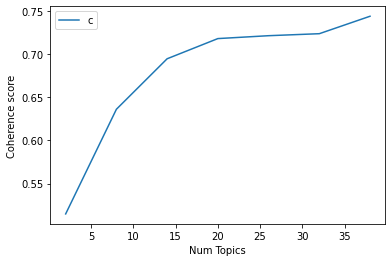

In [16]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [17]:
#plot suggests ~20 topics, as that's where things start to level off
num_topics = 20
for i in range(num_topics):
    print("topic %s:\t%s" % (i, ' '.join([term for term, freq in lda_model.show_topic(i, topn=10)])))

topic 0:	need help black happy okay brian wear party throat nah
topic 1:	shooting police fuck school year shot call ball yo anyone
topic 2:	think say lmao play plant camp cool terrorize people loot
topic 3:	right see time go hand next shut catch bomb come
topic 4:	get school student day gun shooter say would look someone
topic 5:	bomb hope back make come never know s love murder
topic 6:	rap way actually whole foot cat oppose brandon platonic metaphorical
topic 7:	care much leave lockdown drive literally get american illegal charge
topic 8:	even drop mental_breakdown die run death feel heart pay sell
topic 9:	https co good murder check man second pass nra hell
topic 10:	try hear believe vote night last bloody war civil ensue
topic 11:	not be do today hell final forever jess ill nigga
topic 12:	elementary first want house put get mad end see gun
topic 13:	like dm random expect tweet idea documentary crime recently suggest
topic 14:	murder get girl week ever kid lose story lol break
topi

In [18]:
lda_viz = gensimvis.prepare(lda_model, corpus, id2word)
lda_viz

/Users/arijitsen/opt/anaconda3/envs/anlp_spacy2/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.316089  0.057330       1        1  16.474592
9     -0.079162 -0.330674       2        1  10.804737
17    -0.002406  0.098367       3        1   9.573060
5      0.020959 -0.043247       4        1   7.125466
15    -0.058118  0.082053       5        1   6.556304
12    -0.087320  0.046706       6        1   6.105682
14    -0.068590 -0.051844       7        1   6.024923
1     -0.023968  0.062363       8        1   5.417662
16    -0.017851  0.049958       9        1   4.794514
8      0.077452 -0.005071      10        1   4.327135
11     0.081192 -0.010289      11        1   4.023024
7      0.024152  0.010692      12        1   3.523344
3      0.036300  0.004995      13        1   2.796984
6      0.073975 -0.000071      14        1   2.577627
19     0.056343  0.008238      15        1   2.556182
2      0.048680  0.006658      16        1   2.163162
0      0.071402  0.001805      17        1   2.039801
10     0.059662  0.002512      18        1   1.573977
18     0.053625  0.004811      19        1   1.117032
13     0.049763  0.004708      20        1   0.424792, topic_info=       Term        Freq       Total Category  logprob  loglift
1     https  150.000000  150.000000  Default  30.0000  30.0000
44       co  131.000000  131.000000  Default  29.0000  29.0000
9        go  110.000000  110.000000  Default  28.0000  28.0000
17     kill   86.000000   86.000000  Default  27.0000  27.0000
232  school   87.000000   87.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
4      ride    0.009999    1.511777  Topic20  -7.4474   0.4428
5      uber    0.009999    1.158927  Topic20  -7.4474   0.7086
6        vp    0.009999    1.158927  Topic20  -7.4474   0.7086
7      able    0.009999    3.547321  Topic20  -7.4474  -0.4101
8    direct    0.009999    1.332631  Topic20  -7.4474   0.5689

[732 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
331       7  0.653457         ab
7        15  0.845709       able
74       14  0.929289   actually
242       7  0.630412        add
460      12  0.470581      agree
...     ...       ...        ...
277       1  0.910702      would
440       8  0.665214      xurdc
263       8  0.950170       year
278       7  0.802390  yesterday
60        8  0.866522         yo

[472 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 10, 18, 6, 16, 13, 15, 2, 17, 9, 12, 8, 4, 7, 20, 3, 1, 11, 19, 14])

/Users/arijitsen/opt/anaconda3/envs/anlp_spacy2/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/arijitsen/opt/anaconda3/envs/anlp_spacy2/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/arijitsen/opt/anaconda3/envs/anlp_spacy2/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/arijitsen/opt/anaconda3/envs/anlp_spacy2/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import